# Robustness of founded policies


1) Regret
2) satisfying
3) signal noise_to_ratio

In [29]:
# Import general python packages
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation
from problem_formulation import sum_over,time_step_0,time_step_1, time_step_2, time_step_3, time_step_4

# Loading in the necessary modules for EMA workbench and functions
from ema_workbench import (Model, MultiprocessingEvaluator, Scenario,
                           Constraint, ScalarOutcome, TimeSeriesOutcome, ArrayOutcome)
from ema_workbench.util import ema_logging
from ema_workbench import save_results, load_results, Policy
from ema_workbench.em_framework.optimization import (EpsilonProgress)
from ema_workbench.analysis import parcoords

### Initializing model

In [9]:

def initialize_model():
    ema_logging.log_to_stderr(ema_logging.INFO)
    print("Initializing model...")
    dike_model, planning_steps = get_model_for_problem_formulation(7)
    print("Model initialized.")
    return dike_model, planning_steps

# Writing a function to create actor specific problem formulations
def problem_formulation_actor(problem_formulation_actor, uncertainties, levers):
    # Load the model:
    function = DikeNetwork()
    # workbench model:
    model = Model('dikesnet', function=function)
    # Outcomes are all costs, thus they have to minimized:
    direction = ScalarOutcome.MINIMIZE

    model.uncertainties = uncertainties
    model.levers = levers

    cost_variables = []
    cost_variables.extend(
    [
        f"{dike}_{e}"
        for e in ["Expected Annual Damage", "Dike Investment Costs"]
        for dike in function.dikelist
    ])
    cost_variables.extend([f"RfR Total Costs"])
    cost_variables.extend([f"Expected Evacuation Costs"])

    if problem_formulation_actor == 6:  # GELDERLAND
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome(f'Total_period_Costs_0',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_0, kind=direction),
            ScalarOutcome(f'Total_period_Costs_1',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_1, kind=direction),
            ScalarOutcome(f'Total_period_Costs_2',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_2, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_3',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_3, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_4',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_4, kind=direction),
            ScalarOutcome('Expected Annual Damage A1_', variable_name='A.1_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A2_', variable_name='A.2_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A3_', variable_name='A.3_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Total Costs', variable_name=cost_variables, function=sum_over, kind=direction),
            ScalarOutcome("Expected Number of Deaths_", variable_name=
            [f"{dike}_Expected Number of Deaths" for dike in function.dikelist], function=sum_over, kind=direction)]


    elif problem_formulation_actor == 7:  # OVERIJSSEL
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome(f'Total_period_Costs_0',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_0, kind=direction),
            ScalarOutcome(f'Total_period_Costs_1',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_1, kind=direction),
            ScalarOutcome(f'Total_period_Costs_2',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_2, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_3',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_3, kind=direction),
            # # ScalarOutcome(f'Total_period_Costs_4',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_4, kind=direction),
            ScalarOutcome('Expected Annual Damage A4_', variable_name='A.4_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A5_', variable_name='A.5_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Total Costs', variable_name=cost_variables, function=sum_over, kind=direction),
            ScalarOutcome("Expected Number of Deaths_", variable_name=
            [f"{dike}_Expected Number of Deaths" for dike in function.dikelist], function=sum_over, kind=direction)]

    else:
        raise TypeError('unknown identifier')
    return model

### Overijssel
if __name__ == '__main__':
    dike_model, planning_steps = initialize_model()

    uncertainties = dike_model.uncertainties
    levers = dike_model.levers
    
    model = problem_formulation_actor(7, uncertainties, levers)

    # Deepcopying the uncertainties and levers
    uncertainties = copy.deepcopy(dike_model.uncertainties)
    levers = copy.deepcopy(dike_model.levers)

    # Running the optimization for Overijssel
    function = DikeNetwork()

Initializing model...
Model initialized.


In [54]:
##### KLEINE EXPLORING
merged_archives= pd.read_csv('Overijssel_MORDM_Policies.csv')

### Gelderland Exploration

policy_set = merged_archives.loc[~merged_archives.iloc[:, 1:51].duplicated()]
policies = merged_archives.iloc[:,1:51]

rcase_policies = []

for i, policy in policies.iterrows():
    rcase_policies.append(Policy(str(i), **policy.to_dict()))

n_scenarios = 2
with MultiprocessingEvaluator(model) as evaluator:
    reference_policies_results = evaluator.perform_experiments(n_scenarios,
                                            rcase_policies)
save_results(reference_policies_results, 'Week25.tar.gz')

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 2 scenarios * 234 policies * 1 model(s) = 468 experiments
100%|████████████████████████████████████████| 468/468 [05:16<00:00,  1.48it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\Gebruiker\OneDrive - Delft University of Technology\EPA\Q4 Model based decision making\epa141A_open\final_ass_time_changed\Week25.tar.gz


### Loading in the datasets

In [2]:
experiments, outcomes = load_results('Week25.tar.gz')

df_exp = pd.DataFrame.from_dict(experiments)
df_out = pd.DataFrame.from_dict(outcomes)

In [3]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 3,A.4_DikeIncrease 4,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_DikeIncrease 3,A.5_DikeIncrease 4,scenario,policy,model
0,70,205.302377,1.0,0.720076,73.16495,1.5,0.389444,254.197053,1.5,0.839219,...,5,0,5,0,0,0,0,0,0,dikesnet
1,32,97.905134,10.0,0.101925,218.44797,10.0,0.757931,156.314574,10.0,0.439384,...,5,0,5,0,0,0,0,1,0,dikesnet
2,70,205.302377,1.0,0.720076,73.16495,1.5,0.389444,254.197053,1.5,0.839219,...,0,1,2,0,0,0,0,0,1,dikesnet
3,32,97.905134,10.0,0.101925,218.44797,10.0,0.757931,156.314574,10.0,0.439384,...,0,1,2,0,0,0,0,1,1,dikesnet
4,70,205.302377,1.0,0.720076,73.16495,1.5,0.389444,254.197053,1.5,0.839219,...,5,0,3,0,0,0,0,0,2,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,32,97.905134,10.0,0.101925,218.44797,10.0,0.757931,156.314574,10.0,0.439384,...,0,0,0,0,0,0,0,1,231,dikesnet
464,70,205.302377,1.0,0.720076,73.16495,1.5,0.389444,254.197053,1.5,0.839219,...,0,0,4,0,0,0,0,0,232,dikesnet
465,32,97.905134,10.0,0.101925,218.44797,10.0,0.757931,156.314574,10.0,0.439384,...,0,0,4,0,0,0,0,1,232,dikesnet
466,70,205.302377,1.0,0.720076,73.16495,1.5,0.389444,254.197053,1.5,0.839219,...,0,1,2,0,1,0,0,0,233,dikesnet


In [4]:
for _ in outcomes:
    print(_)

Total_period_Costs_0
Total_period_Costs_1
Total_period_Costs_2
Expected Annual Damage A4_
Expected Annual Damage A5_
Total Costs
Expected Number of Deaths_


In [5]:
policies = experiments.iloc[:,21:]
policies

,0_RfR 1,0_RfR 2,0_RfR 3,0_RfR 4,1_RfR 0,1_RfR 1,1_RfR 2,1_RfR 3,1_RfR 4,2_RfR 0,...,A.4_DikeIncrease 3,A.4_DikeIncrease 4,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_DikeIncrease 3,A.5_DikeIncrease 4,scenario,policy,model
0,0,0,0,0,0,0,0,0,0,0,...,5,0,5,0,0,0,0,0,0,dikesnet
1,0,0,0,0,0,0,0,0,0,0,...,5,0,5,0,0,0,0,1,0,dikesnet
2,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,0,1,dikesnet
3,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,1,1,dikesnet
4,0,0,0,0,0,0,0,0,0,0,...,5,0,3,0,0,0,0,0,2,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,231,dikesnet
464,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,232,dikesnet
465,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,1,232,dikesnet
466,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,1,0,0,0,233,dikesnet


In [6]:
df_out

,Total_period_Costs_0,Total_period_Costs_1,Total_period_Costs_2,Expected Annual Damage A4_,Expected Annual Damage A5_,Total Costs,Expected Number of Deaths_
0,1.505273e+08,0.000000e+00,3.769116e+07,0.000000e+00,0.000000e+00,2.852048e+08,0.000000
1,7.818861e+08,6.313588e+08,7.703824e+08,0.000000e+00,1.608975e+08,3.938379e+09,0.533048
2,1.414416e+08,2.744715e+06,1.889763e+08,2.492026e+06,0.000000e+00,4.308914e+08,0.001679
3,7.831834e+08,6.450127e+08,9.359050e+08,0.000000e+00,2.398935e+08,4.152470e+09,0.546150
4,8.365303e+07,1.346466e+07,4.966172e+07,6.479541e+06,0.000000e+00,2.601692e+08,0.064704
...,...,...,...,...,...,...,...
463,7.728718e+08,7.068639e+08,9.932058e+08,0.000000e+00,5.977123e+08,4.328954e+09,0.485759
464,1.477806e+08,4.639118e+05,3.116391e+07,0.000000e+00,0.000000e+00,2.459345e+08,0.000340
465,7.919675e+08,6.447398e+08,7.789192e+08,0.000000e+00,3.231332e+08,3.608270e+09,0.393924
466,1.203729e+08,1.154587e+06,1.798321e+08,4.816096e+06,0.000000e+00,3.704277e+08,0.000406


### 1. Regret

In [21]:
import pandas as pd
import numpy as np

def calculate_regret(data, best):
    return np.abs(best-data)

worstcase_regret = {}
worstcase_max_regret = {}

for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # Create a DataFrame with all the relevant information
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name], 
        "policy": experiments['policy'],
        "scenario_id": experiments['scenario']
    })
    
    # Reorient the data by indexing with policy and scenario_id
    data = data.pivot(index='scenario_id', columns='policy')
    
    # Flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
   
    # Control the broadcasting by converting to NumPy arrays
    max_values = data.max(axis=1).to_numpy()[:, np.newaxis]
    data_values = data.to_numpy()
    
    # Calculate the outcome regret
    outcome_regret = np.abs(max_values - data_values)
    
    # Store the results
    worstcase_regret[outcome.name] = outcome_regret
    worstcase_max_regret[outcome.name] = outcome_regret.max(axis=0)

# Convert the results to DataFrames if needed
#worstcase_regret_df = pd.DataFrame(worstcase_regret)
# worstcase_max_regret_df = pd.DataFrame(worstcase_max_regret)
# 
# worstcase_regret_df, worstcase_max_regret_df

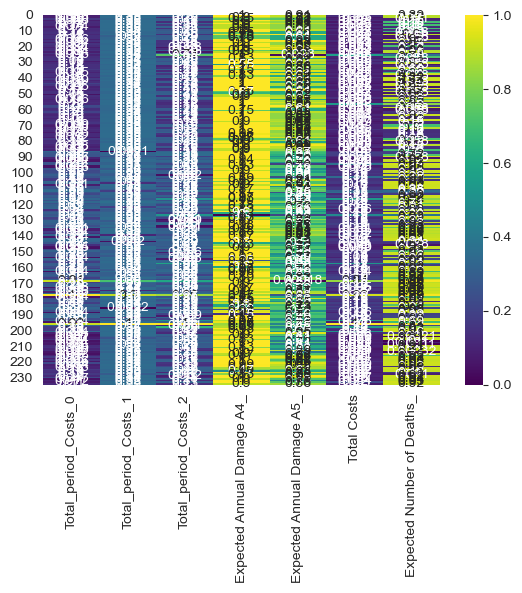

In [22]:
worstcase_max_regret = pd.DataFrame(worstcase_max_regret)
sns.heatmap(worstcase_max_regret/worstcase_max_regret.max(), cmap='viridis', annot=True)
plt.show()

IndexError: list index out of range

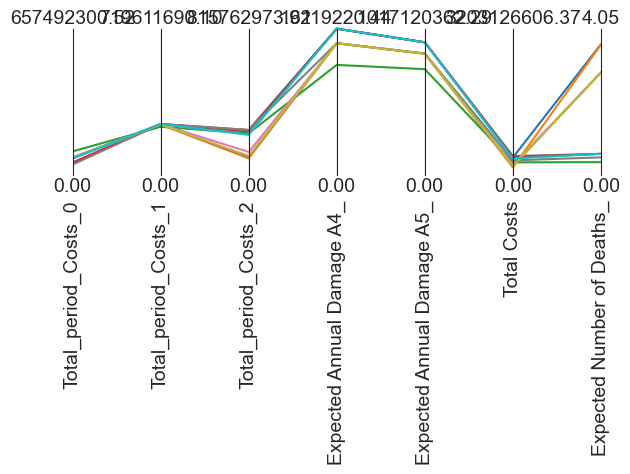

In [23]:
colors = sns.color_palette()

data = worstcase_max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Total_period_Costs_0', 'Total_period_Costs_1', 'Total_period_Costs_2','Expected Annual Damage A4_', 'Expected Annual Damage A5_', 'Total Costs', 'Expected Number of Deaths_']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [ ]:
#no need for distribution as max regret is what we are intrested in especially with deaths and damages.. MAX regret is how good it could have been in a certain scenario if you would have chosen another policy

### 2. Satisfying

### 3. Signal to Noise

In [7]:
def signalnoise(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    #We minimize all objectives therefore a lower mean and lower std is wanted, so we want the outcome to be as small as possible
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [11]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = signalnoise(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Total_period_Costs_0,Total_period_Costs_1,Total_period_Costs_2,Expected Annual Damage A4_,Expected Annual Damage A5_,Total Costs,Expected Number of Deaths_
0,1.471719e+17,9.965349e+16,1.480171e+17,0.000000e+00,6.472003e+15,3.857371e+18,0.071035
1,1.483426e+17,1.040085e+17,2.100515e+17,1.552548e+12,1.438722e+16,4.264335e+18,0.074569
2,1.321191e+17,1.102299e+17,1.631953e+17,9.075930e+12,3.009085e+16,4.067999e+18,3.576227
3,1.475593e+17,9.964981e+16,1.481001e+17,0.000000e+00,6.472003e+15,3.857783e+18,3.157109
4,1.405762e+17,1.040068e+17,2.068252e+17,1.552548e+12,1.438722e+16,4.211831e+18,0.429519
...,...,...,...,...,...,...,...
229,1.209026e+17,9.859171e+16,1.994855e+17,0.000000e+00,5.017029e+15,4.091292e+18,0.044525
230,1.581792e+17,1.101575e+17,1.692844e+17,1.872053e+12,3.037582e+16,4.129319e+18,0.051536
231,1.473143e+17,1.248141e+17,2.373117e+17,0.000000e+00,8.931500e+16,4.656095e+18,0.058942
232,1.513434e+17,1.039223e+17,1.514360e+17,0.000000e+00,2.610376e+16,3.239782e+18,0.038794


C:\Users\CLDert\AppData\Roaming\Python\Python311\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


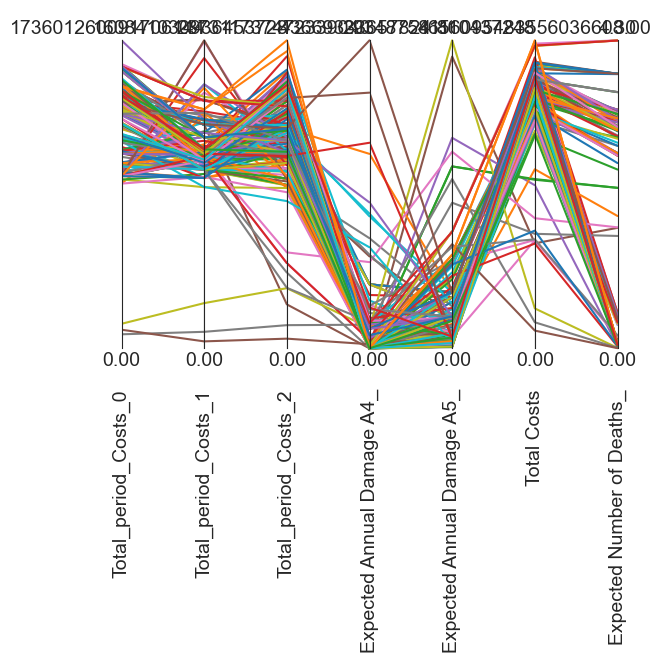

In [13]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Total_period_Costs_0', 'Total_period_Costs_1', 'Total_period_Costs_2','Expected Annual Damage A4_', 'Expected Annual Damage A5_', 'Total Costs', 'Expected Number of Deaths_']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [ ]:
#This shows the Signal to Noice, which is expected * standard deviation for our minimization. a lower score is better. This is about over different scenarios the average and standard deviation, punishing for too much deviation over the scenarios.